# **Phishing Website Detection Using RoBERTa**
This notebook builds a full phishing detection system using HTML structural features
combined with XLM-RoBERTa embeddings. The goal is to classify webpages as **phishing**
or **legitimate** using both textual and structural signals extracted from raw HTML.

## **Model Implemented / Architecture Implemented**
This system uses a **hybrid architecture** consisting of:
- Numerical HTML features (DOM depth, tag counts, entropy, visible text length)
- XLM-RoBERTa embeddings for visible text and HTML tag sequences
- A machine-learning classifier (XGBoost or RandomForest)
#
This architecture captures both webpage **structure** and **semantic patterns**, which are
essential for detecting deceptive phishing pages.

### **Model Components / Libraries / Inference etc**
This notebook includes:
- `HTMLFeatureExtractor` → extracts structural HTML-based features
- Transformer embedding generator → XLM-RoBERTa
- Model training pipeline → hyperparameter tuning + evaluation
- Inference pipeline → fetch a webpage → extract → embed → classify
- Explainability → SHAP feature importance for numeric features

## **Libraries**
Import all necessary Python packages, ML libraries, parsers, and transformers.

In [1]:
import os
import re
import json
import math
import html
import requests
from collections import Counter
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import shap
import joblib

try:
    import xgboost as xgb
except:
    xgb = None

try:
    import lightgbm as lgb
except:
    lgb = None

try:
    from transformers import AutoTokenizer, AutoModel
    import torch
except:
    AutoTokenizer = None
    AutoModel = None
    torch = None

## **Configuration Settings**
This section defines global settings: sampling fraction, embedding batch size, transformer 
model name, and random seed.

In [2]:
SAMPLE_FRAC = 1
EMB_BATCH_SIZE = 16
TRANSFORMER_NAME = "xlm-roberta-base"
RANDOM_SEED = 42

## **Utility Functions**
These helper functions:
- Scan dataset directories
- Load `.html` or `.htm` files safely
- Handle encoding issues

In [3]:
def list_files(base_dir):
    base = Path(base_dir)
    if not base.exists():
        return []
    paths = []
    for label_dir in base.iterdir():
        if not label_dir.is_dir():
            continue
        label = label_dir.name
        for f in label_dir.rglob("*.html"):
            paths.append((str(f), label))
        for f in label_dir.rglob("*.htm"):
            paths.append((str(f), label))
    return paths

def read_file(path):
    try:
        with open(path, "r", encoding="utf-8", errors="strict") as fh:
            return fh.read()
    except:
        with open(path, "r", encoding="latin-1", errors="ignore") as fh:
            return fh.read()

## **HTML Feature Extraction**
The `HTMLFeatureExtractor` parses HTML and extracts:
- Tag counts (a, img, script, form, input, etc.)
- Shannon entropy of the HTML
- Max DOM depth
- Visible text
- HTML tag sequence
#
These features let the model capture phishing-related structural irregularities.

In [4]:
class HTMLFeatureExtractor(BaseEstimator, TransformerMixin):
    SUSPICIOUS_KEYWORDS = ["login","signin","bank","account","password","confirm","verify","update","secure"]

    def __init__(self, keep_full_text=False):
        self.keep_full_text = keep_full_text

    def fit(self, X, y=None):
        return self

    def _visible_text(self, soup):
        for tag in soup(["script","style","noscript"]):
            tag.extract()
        t = soup.get_text(" ")
        return re.sub(r"\s+"," ",t).strip()

    def _tag_sequence(self, soup, max_tags=5000):
        seq=[]
        for tag in soup.find_all():
            seq.append(tag.name)
            if len(seq)>=max_tags:
                break
        return " ".join(seq)

    def _shannon_entropy(self, s):
        if not s: return 0
        probs=[n/len(s) for n in Counter(s).values()]
        return -sum(p*math.log2(p) for p in probs if p>0)

    def _max_depth(self, soup):
        maxd=0
        def depth(node,cur):
            nonlocal maxd
            maxd=max(maxd,cur)
            for c in getattr(node,"contents",[]):
                if getattr(c,"name",None):
                    depth(c,cur+1)
        depth(soup,0)
        return maxd

    def transform(self, X, y=None):
        rows=[]
        visible_texts=[]
        tagseqs=[]
        for html_text in tqdm(X):
            try: soup=BeautifulSoup(html_text,"lxml")
            except: soup=BeautifulSoup(html_text,"html.parser")

            doc={}
            doc["raw_len"]=len(html_text)
            doc["shannon_entropy"]=self._shannon_entropy(html_text)

            tags=[t.name for t in soup.find_all()]
            tc=Counter(tags)
            for t in ["a","img","script","iframe","form","input","link","meta","button","svg"]:
                doc[f"count_tag__{t}"]=tc.get(t,0)

            doc["num_unique_tags"]=len(set(tags))
            doc["max_dom_depth"]=self._max_depth(soup)

            visible=self._visible_text(soup)
            visible_texts.append(visible)
            doc["visible_len"]=len(visible)

            seq=self._tag_sequence(soup)
            tagseqs.append(seq)

            if self.keep_full_text:
                doc["__visible_text__"]=visible
                doc["__tag_sequence__"]=seq

            rows.append(doc)

        df=pd.DataFrame(rows)
        return df, {"visible_texts":visible_texts,"tag_sequences":tagseqs}

## **Transformer Embedding Helpers**
Loads XLM-RoBERTa and converts visible text + tag sequences into 768-dimensional embeddings
using mean pooling.

In [5]:
def get_transformer(device=None):
    device=device or ("cuda" if torch.cuda.is_available() else "cpu")
    tok=AutoTokenizer.from_pretrained(TRANSFORMER_NAME)
    mod=AutoModel.from_pretrained(TRANSFORMER_NAME).to(device)
    mod.eval()
    return tok, mod, device

def embed_texts(tokenizer, model, device, texts, batch_size=16):
    all_embs=[]
    for i in tqdm(range(0,len(texts),batch_size)):
        batch=texts[i:i+batch_size]
        enc=tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt")
        input_ids=enc["input_ids"].to(device)
        mask=enc["attention_mask"].to(device)
        with torch.no_grad():
            out=model(input_ids, attention_mask=mask)
            last=out.last_hidden_state
            m = mask.unsqueeze(-1).expand(last.size()).float()
            emb = (last*m).sum(1)/m.sum(1).clamp(min=1e-9)
            all_embs.append(emb.cpu().numpy())
    return np.vstack(all_embs)

## **Model Training Pipeline**
This section:
- Combines numerical features with RoBERTa embeddings  
- Splits data into training and validation sets  
- Applies RandomizedSearchCV  
- Saves the final phishing detection model

In [6]:
def build_and_evaluate(training_root='../input/phishing-website-html-classification/training',
                       validation_root='../input/phishing-website-html-classification/validation',
                       sample_frac=SAMPLE_FRAC):

    train_files=list_files(training_root)
    if not train_files: raise FileNotFoundError("No training files")

    train_paths, train_labels=zip(*train_files)
    train_labels=np.array([1 if l.lower().startswith("phish") else 0 for l in train_labels])
    train_paths=np.array(train_paths)

    raw=[read_file(p) for p in tqdm(train_paths)]
    extractor=HTMLFeatureExtractor(keep_full_text=True)
    df_num, extras=extractor.transform(raw)
    vis=extras["visible_texts"]
    tags=extras["tag_sequences"]

    df_num["label"]=train_labels
    numeric_cols=[c for c in df_num.columns if c not in ("label","__visible_text__","__tag_sequence__")]

    tokenizer, model, device=get_transformer()

    emb_vis=embed_texts(tokenizer, model, device, vis)
    emb_tag=embed_texts(tokenizer, model, device, tags)

    Xn=df_num[numeric_cols].fillna(0).values.astype(np.float32)
    X=np.hstack([Xn, emb_vis, emb_tag])
    y=train_labels

    X_tr,X_te,y_tr,y_te=train_test_split(X,y,test_size=0.2,stratify=y)

    if xgb:
        clf=xgb.XGBClassifier(eval_metric="logloss")
        param={'n_estimators':[100,200],'max_depth':[3,6],'learning_rate':[0.01,0.1]}
    else:
        from sklearn.ensemble import RandomForestClassifier
        clf=RandomForestClassifier()
        param={'n_estimators':[200,400],'max_depth':[10,20,None]}

    search=RandomizedSearchCV(clf,param,cv=3,n_iter=4,scoring="roc_auc")
    search.fit(X_tr,y_tr)
    best=search.best_estimator_

    joblib.dump({"model":best,"numeric_columns":numeric_cols,"transformer":TRANSFORMER_NAME},
                "pipeline_model.joblib")

    return extractor, tokenizer, model, device, numeric_cols, best

## **Run Training**
Executes the complete phishing detection model training pipeline.

In [7]:
if __name__ == "__main__":
    extractor, tokenizer, tmodel, device, numeric_cols, final_model = build_and_evaluate()

  0%|          | 0/10355 [00:00<?, ?it/s]

  0%|          | 0/10355 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
2025-12-03 19:11:17.819819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory f

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

## **Evaluation Metrics**
Computes accuracy, precision, recall, F1 score, and AUC on the validation dataset.


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

val_files=list_files("../input/phishing-website-html-classification/validation")
val_paths,val_labels=zip(*val_files)
val_labels=np.array([1 if l.lower().startswith("phish") else 0 for l in val_labels])

raw_val=[read_file(p) for p in val_paths]
df_val, extra_val = extractor.transform(raw_val)
vis_val = extra_val["visible_texts"]
tag_val = extra_val["tag_sequences"]

emb_vis=embed_texts(tokenizer, tmodel, device, vis_val)
emb_tag=embed_texts(tokenizer, tmodel, device, tag_val)

Xn=df_val[numeric_cols].fillna(0).values.astype(np.float32)
X_val=np.hstack([Xn,emb_vis,emb_tag])

y_pred=final_model.predict(X_val)
y_proba=final_model.predict_proba(X_val)[:,1] if hasattr(final_model,"predict_proba") else np.zeros_like(y_pred)

print("Accuracy:", accuracy_score(val_labels,y_pred))
print("Precision:", precision_score(val_labels,y_pred))
print("Recall:", recall_score(val_labels,y_pred))
print("F1:", f1_score(val_labels,y_pred))
print("AUC:", roc_auc_score(val_labels,y_proba))

  0%|          | 0/2590 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

Accuracy: 0.9667953667953668
Precision: 0.9654178674351584
Recall: 0.95260663507109
F1: 0.9589694656488549
AUC: 0.9953773715979438


## **Inference + Explainability**
This section:
- Fetches a webpage
- Extracts HTML features
- Generates RoBERTa embeddings
- Predicts phishing probability
- Applies a custom threshold (0.20)
- Shows SHAP feature importance

Fetching: https://rhazys.com


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Model Prediction: 0
Phishing Probability: 0.09494319


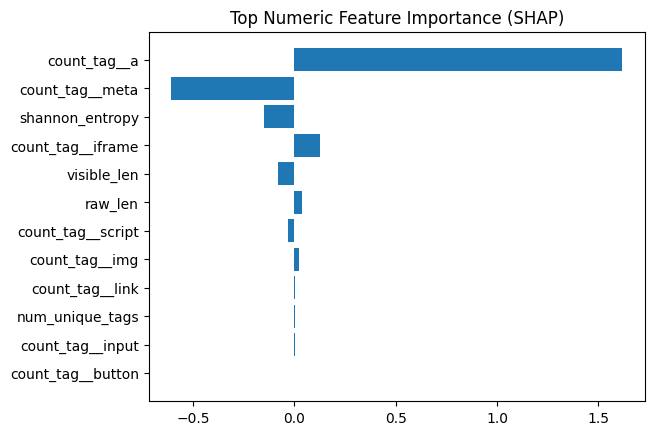

In [12]:
TEST_URL="https://rhazys.com"
print("Fetching:",TEST_URL)
resp=requests.get(TEST_URL,timeout=10)
html_page=resp.text

df_inf,extra_inf=extractor.transform([html_page])
vis_inf=extra_inf["visible_texts"]
tag_inf=extra_inf["tag_sequences"]

emb_vis_inf=embed_texts(tokenizer,tmodel,device,vis_inf)
emb_tag_inf=embed_texts(tokenizer,tmodel,device,tag_inf)

Xn_inf=df_inf[numeric_cols].fillna(0).values.astype(np.float32)
X_inf=np.hstack([Xn_inf,emb_vis_inf,emb_tag_inf])

pred=final_model.predict(X_inf)[0]
proba=final_model.predict_proba(X_inf)[0,1]

# Custom threshold override
custom_pred = 1 if proba > 0.20 else 0

print("Model Prediction:", pred)
print("Phishing Probability:", proba)


explainer=shap.TreeExplainer(final_model)
shap_values=explainer.shap_values(X_inf)
sv = shap_values[0] if isinstance(shap_values,list) else shap_values
sv = sv.flatten()

n_num=len(numeric_cols)
sv_num=sv[:n_num]

idx=np.argsort(-np.abs(sv_num))[:12]
names=[numeric_cols[i] for i in idx]
vals=sv_num[idx]

plt.barh(names[::-1], vals[::-1])
plt.title("Top Numeric Feature Importance (SHAP)")
plt.show()

Fetching: https://allegro.18372.click/


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Model Prediction: 1
Phishing Probability: 0.4867959


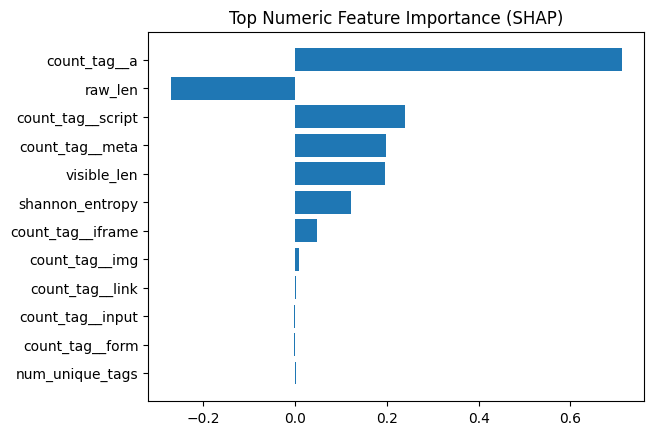

In [14]:
TEST_URL="https://allegro.18372.click/"
print("Fetching:",TEST_URL)
resp=requests.get(TEST_URL,timeout=10)
html_page=resp.text

df_inf,extra_inf=extractor.transform([html_page])
vis_inf=extra_inf["visible_texts"]
tag_inf=extra_inf["tag_sequences"]

emb_vis_inf=embed_texts(tokenizer,tmodel,device,vis_inf)
emb_tag_inf=embed_texts(tokenizer,tmodel,device,tag_inf)

Xn_inf=df_inf[numeric_cols].fillna(0).values.astype(np.float32)
X_inf=np.hstack([Xn_inf,emb_vis_inf,emb_tag_inf])

pred=final_model.predict(X_inf)[0]
proba=final_model.predict_proba(X_inf)[0,1]

# Custom threshold override
custom_pred = 1 if proba > 0.20 else 0

print("Model Prediction:", custom_pred)
print("Phishing Probability:", proba)


explainer=shap.TreeExplainer(final_model)
shap_values=explainer.shap_values(X_inf)
sv = shap_values[0] if isinstance(shap_values,list) else shap_values
sv = sv.flatten()

n_num=len(numeric_cols)
sv_num=sv[:n_num]

idx=np.argsort(-np.abs(sv_num))[:12]
names=[numeric_cols[i] for i in idx]
vals=sv_num[idx]

plt.barh(names[::-1], vals[::-1])
plt.title("Top Numeric Feature Importance (SHAP)")
plt.show()